## Import libraries

In [1]:
# system and performance
import gc
import time
import os
import pickle


# date management
import datetime
import calendar


# data management
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

from itertools import product

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# machine learning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('directory '+path+' created succesfully !')
    else:
        print('directory '+path+' already exists')

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
# path to data
RAW_DATA_FOLDER = '../data/raw/'
DATA_FOLDER = '../data/'

##### Define core variable space and macro to reset variable space

In [5]:
loaded=%who_ls
loaded.append('loaded')

In [6]:
all_vars=%who_ls
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var

In [7]:
%macro reset_variable_space 6
loaded.append('reset_variable_space')

Macro `reset_variable_space` created. To execute, type its name (without quotes).
=== Macro contents: ===
all_vars=get_ipython().run_line_magic('who_ls', '')
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var
 

## -------------------------------------------------------------

# 6 - TRAINING FOR PREDICTION

## Functions for training and validation

In [8]:
# SPLIT TRAIN-TEST SET
def datasplit_train_test(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    # TRAINING SET
    X_train=train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),:].astype(np.float32)
    Y_train=X_train['item_quantity'].astype(np.float32)
    X_train.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_train.shape, Y_train.shape)

    # TEST SET
    X_test=train_df.loc[train_df['month_id']==34,:].astype(np.float32)
    X_test.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_test.shape)

    return (X_train,Y_train,X_test)





# SPLIT TRAINING SET MONTH BY MONTH
def datasplit_evalset(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    eval_set=[]
    for mid in train_df['month_id'].unique():
        if (mid>=month_id_first)&(mid<34):
            X_val=train_df.loc[(train_df['month_id']==mid),:].astype(np.float32)
            Y_val=X_val['item_quantity'].astype(np.float32)
            X_val.drop(['month_id','item_quantity'],axis=1,inplace=True)
            eval_set.append((X_val,Y_val))
        
    return eval_set

In [9]:
# ANALYSIS OF TARGET VALUE AND NAIVE PREDICTIONS
def target_analysis_test(train_df,month_id_first=0):

    # split dataset
    (X_train,Y_train,_) = datasplit_train_test(train_df,month_id_first)
    evalset = datasplit_evalset(train_df,month_id_first)

    # BASE SCORE
    base_score=Y_train.mean()
    base_score_evalset=[Y.mean() for (_,Y) in evalset]

    # BENCHMARK (guess with 0 everywhere)
    Y_guess_train=0*Y_train
    rmse_guess_train=np.sqrt(mean_squared_error(Y_train, Y_guess_train))

    Y_base_train=0*Y_train+base_score
    rmse_base_train=np.sqrt(mean_squared_error(Y_train, Y_base_train))

    print('#### TRAINING SET ###')
    print('mean target value: '+str(base_score))
    print('RMSE (guess,base): '+str(rmse_guess_train)+' , '+str(rmse_base_train))

    rmse_guess_evalset=[]
    rmse_base_evalset=[]
    for (_,Y) in evalset:
        Y_guess=0*Y
        rmse_guess_evalset.append(np.sqrt(mean_squared_error(Y, Y_guess)))

        Y_base=0*Y+Y.mean()
        rmse_base_evalset.append(np.sqrt(mean_squared_error(Y, Y_base)))

    print('#### EVAL SET ###')
    print('mean target value: '+str([round(b*1e4)/1e4 for b in base_score_evalset]))
    print('RMSE (guess): '+str([round(b*1e2)/1e2 for b in rmse_guess_evalset]))
    print('RMSE (base): '+str([round(b*1e2)/1e2 for b in rmse_base_evalset]))

    fig,axes=plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),base_score_evalset,'-o')
    axes[0].set_xlabel('month_id')
    axes[0].set_ylabel('mean of target value')
    axes[0].grid(True)
    axes[0].set_ylim(bottom=0)

    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_guess_evalset,'-o')
    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_base_evalset,'-o')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse')
    axes[1].legend(['guess = 0','mean value'])
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)
    
    return rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset

In [10]:
# PERFORMANCES ON TRAINING SET
def performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset):

    rmse_evalset_last=[]
    rmse_evalset_min=[]
    for evset in xgbreg.evals_result().values():
        rmse_evalset_last.append(evset['rmse'][-1])
        rmse_evalset_min.append(min(evset['rmse']))

    # display
    print('#### TRAINING SET ###')
    print('RMSE (last, min, base, guess): '+str(rmse_evalset_last[0]) +' , '+str(rmse_evalset_min[0])+' , '+str(rmse_base_train)+' , '+str(rmse_guess_train))
    print()
    print('#### EVAL SET ###')
    print('RMSE (last): '+str([round(b*1e4)/1e4 for b in rmse_evalset_last[1:]]))
    print('RMSE (min): '+str([round(b*1e4)/1e4 for b in rmse_evalset_min[1:]]))
    print('RMSE (base): '+str([round(b*1e4)/1e4 for b in rmse_base_evalset]))
    print('RMSE (guess): '+str([round(b*1e4)/1e4 for b in rmse_guess_evalset]))


    fig,axes=plt.subplots(1,2,figsize=(15,5))
    for i in range(1,len(xgbreg.evals_result())):
        evset=xgbreg.evals_result()['validation_'+str(i)]['rmse']
        axes[0].plot(evset,'-o')
    axes[0].legend(range(0,len(eval_set)))
    axes[0].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=5)


    axes[1].plot(rmse_evalset_last[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_last[1:])+rmse_evalset_last[0],'k')
    axes[1].plot(rmse_evalset_min[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_min[1:])+rmse_evalset_last[0],'r')
    axes[1].plot(rmse_guess_evalset,'k-s')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse (last,min)')
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)

In [11]:
# FEATURE IMPORTANCE
def plot_feature_importance(xgbreg,X_train):
    # gain     := improvement in accuracy resulting from a split according to this feature (measured by a reduction of the optimization metric)
    # weight   := number of times a feature is used to split the data across all trees
    # coverage := number of observations that are classified according to this feature in the tree

    n_features=len(X_train.columns)
    
    fi_types=[ 'total_gain' , 'gain', 'weight', 'cover' , 'total_cover']
    xgb_fi=pd.DataFrame(index=X_train.columns)
    for typ in fi_types:
        xgb_fi[typ]=pd.Series(data=xgbreg.get_booster().get_score(importance_type=typ),index=X_train.columns)

    xgb_fi.fillna(0,inplace=True)
    xgb_fi=xgb_fi.sort_values(by='gain',ascending=True)

    fig,ax=plt.subplots(1,5,figsize=(18,np.floor(n_features/2.5)))
    for i,typ in enumerate(fi_types[0:5]):
        if i==0:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values)
        else:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values,tick_label=[None])
        ax[i].grid(True)
        ax[i].set_title(typ)

In [12]:
loaded=%who_ls
loaded.append('loaded')

## ----------------------------------------------

In [13]:
# create directories
create_directory(os.path.join(DATA_FOLDER, 'predictions'))
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/'))

directory ../data/predictions created succesfully !
directory ../data/predictions/models/ created succesfully !


## SENIORITY 0

### Import and process training set

In [14]:
dataset_name='train_0_pred'
month_id_first=18

train_X=pd.read_pickle(os.path.join(DATA_FOLDER,'training/'+dataset_name+'.pkl'))

print(train_X.info(null_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327378 entries, 4466093 to 10842248
Data columns (total 90 columns):
month_id                                                                      327378 non-null int8
item_category_id                                                              327378 non-null int8
item_quantity                                                                 327378 non-null float32
shop_months_since_opening                                                     327378 non-null int8
shop_opening                                                                  327378 non-null bool
item_category_freq                                                            327378 non-null float32
item_supercategory_freq                                                       327378 non-null float32
item_category_console_freq                                                    327378 non-null float32
item_category_digital_freq                                                   

(230922, 88) (230922,)
(16086, 88)
#### TRAINING SET ###
mean target value: 0.6440226435661316
RMSE (guess,base): 2.4352796 , 2.348578669899613
#### EVAL SET ###
mean target value: [0.4298, 0.7264, 0.9916, 0.6301, 0.9471, 0.6649, 0.187, 0.5903, 0.6096, 0.8243, 0.7468, 0.532, 0.3349, 0.4065, 0.6693, 0.5208]
RMSE (guess): [1.8, 2.49, 3.35, 2.32, 3.17, 2.29, 0.94, 2.15, 2.2, 2.95, 2.9, 2.04, 1.4, 1.66, 2.69, 2.16]
RMSE (base): [1.75, 2.38, 3.2, 2.23, 3.03, 2.19, 0.92, 2.07, 2.12, 2.83, 2.8, 1.97, 1.36, 1.61, 2.6, 2.1]


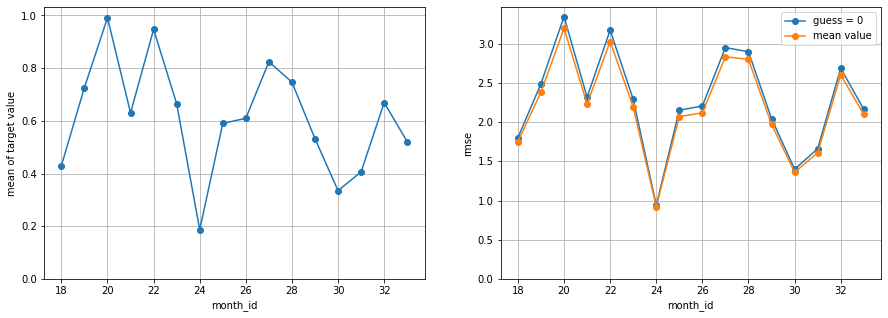

In [15]:
# analyse dataset
rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset = target_analysis_test(train_X,month_id_first=18)

In [16]:
features_to_keep_0=[]

#--------------
# CATEGORY
features_to_keep_0+=['item_category_id']

features_to_keep_0+=['item_category_freq']
features_to_keep_0+=['item_supercategory_freq']
features_to_keep_0+=['item_category_console_freq']
#features_to_keep_0+=['item_category_digital_freq']

features_to_keep_0+=['item_category_freq_in_seniority']
features_to_keep_0+=['item_supercategory_freq_in_seniority']
features_to_keep_0+=['item_category_console_freq_in_seniority']
#features_to_keep_0+=['item_category_digital_freq_in_seniority']

#features_to_keep_0+=['category_semiannual_avg_recent_rsd']
#features_to_keep_0+=['category_semiannual_avg_annual_rsd']


#--------------
# SHOP
#features_to_keep_0+=['shop_months_since_opening']
#features_to_keep_0+=['shop_opening']










#--------------
# PRICES

# typical prices

features_to_keep_0+=['shop_category_price_median_absolute_mean']         
#features_to_keep_0+=['shop_category_price_median_recent_mean']           
features_to_keep_0+=['shop_category_price_median_lag_12']                

features_to_keep_0+=['category_price_median_recent_mean']                
features_to_keep_0+=['category_price_median_lag_12']                     

#features_to_keep_0+=['supercategory_price_median_recent_mean']       
features_to_keep_0+=['supercategory_price_median_lag_12']                

features_to_keep_0+=['category_price_min_absolute_min']                  
features_to_keep_0+=['category_price_max_absolute_max']                  

features_to_keep_0+=['category_price_min_annual_min']                    
features_to_keep_0+=['category_price_max_annual_max']                    

features_to_keep_0+=['category_price_median_compared_to_supercategory_price_median_absolute_mean']










#--------------
# SHOP
#features_to_keep_0+=['shop_avg_sales_seniority_0_absolute_mean']
#features_to_keep_0+=['shop_avg_sales_seniority_0_annual_mean']           
features_to_keep_0+=['shop_avg_sales_seniority_0_semiannual_mean']       
#features_to_keep_0+=['shop_avg_sales_seniority_0_recent_mean']           
#features_to_keep_0+=['shop_avg_sales_seniority_0_lag_1']                 
#features_to_keep_0+=['shop_avg_sales_seniority_0_lag_12']                


#--------------
# SUPERCATEGORY
#features_to_keep_0+=['supercategory_avg_sales_seniority_0_absolute_mean']
#features_to_keep_0+=['supercategory_avg_sales_seniority_0_annual_mean']          
features_to_keep_0+=['supercategory_avg_sales_seniority_0_semiannual_mean']   
#features_to_keep_0+=['supercategory_avg_sales_seniority_0_recent_mean']          
#features_to_keep_0+=['supercategory_avg_sales_seniority_0_lag_1']                
features_to_keep_0+=['supercategory_avg_sales_seniority_0_lag_12']            


#--------------
# SHOP-SUPERCATEGORY
#features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_absolute_mean']
features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_annual_mean']      
#features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_semiannual_mean']     
#features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_recent_mean']         
#features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_lag_1']               
features_to_keep_0+=['shop_supercategory_avg_sales_seniority_0_lag_12']              




#--------------
# CATEGORY
#features_to_keep_0+=['category_avg_sales_seniority_0_absolute_mean']
features_to_keep_0+=['category_avg_sales_seniority_0_annual_mean']        
features_to_keep_0+=['category_avg_sales_seniority_0_semiannual_mean']    
#features_to_keep_0+=['category_avg_sales_seniority_0_recent_mean']        
#features_to_keep_0+=['category_avg_sales_seniority_0_lag_1']              
#features_to_keep_0+=['category_avg_sales_seniority_0_lag_12']             



#--------------
# SHOP-CATEGORY
#features_to_keep_0+=['shop_category_avg_sales_seniority_0_absolute_mean']
features_to_keep_0+=['shop_category_avg_sales_seniority_0_annual_mean']        
features_to_keep_0+=['shop_category_avg_sales_seniority_0_semiannual_mean']    
features_to_keep_0+=['shop_category_avg_sales_seniority_0_recent_mean']        
features_to_keep_0+=['shop_category_avg_sales_seniority_0_lag_1']              
features_to_keep_0+=['shop_category_avg_sales_seniority_0_lag_12']             





#--------------
# SPATIAL TRENDS
#features_to_keep_0+=['shop_category_avg_sales_compared_to_category_absolute_mean']
features_to_keep_0+=['shop_category_avg_sales_compared_to_category_annual_mean']                  
#features_to_keep_0+=['shop_category_avg_sales_compared_to_category_semiannual_mean']
features_to_keep_0+=['shop_category_avg_sales_compared_to_category_recent_mean']                  
#features_to_keep_0+=['shop_category_avg_sales_compared_to_category_lag_1']
features_to_keep_0+=['shop_category_avg_sales_compared_to_category_lag_12']                       

#features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_absolute_mean']
#features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_annual_mean']       
#features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_semiannual_mean']
features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_recent_mean']        
#features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_lag_1']
#features_to_keep_0+=['shop_supercategory_avg_sales_compared_to_supercategory_lag_12']            


# TEMPORAL TRENDS
#features_to_keep_0+=['shop_avg_sales_compare_recent_mean_to_annual_mean']          
#features_to_keep_0+=['shop_avg_sales_compare_lag1_to_annual_mean']
#features_to_keep_0+=['shop_avg_sales_compare_lag12_to_annual_mean']                

features_to_keep_0+=['supercategory_avg_sales_compare_recent_mean_to_annual_mean'] 
#features_to_keep_0+=['supercategory_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_0+=['supercategory_avg_sales_compare_lag12_to_annual_mean']       

#features_to_keep_0+=['category_avg_sales_compare_recent_mean_to_annual_mean']    
#features_to_keep_0+=['category_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_0+=['category_avg_sales_compare_lag12_to_annual_mean']           

features_to_keep_0+=['category_avg_sales_compared_to_supercategory_recent_mean']  
#features_to_keep_0+=['category_avg_sales_compared_to_supercategory_lag_1']
#features_to_keep_0+=['category_avg_sales_compared_to_supercategory_lag_12']        


# TEMPORAL TRENDS FOR SENIORITY 0 (months of the year where seniority 0 is boosted)
#features_to_keep_0+=['shop_avg_sales_seniority_0_compare_recent_mean_to_annual_mean']
#features_to_keep_0+=['shop_avg_sales_seniority_0_compare_lag1_to_annual_mean']
#features_to_keep_0+=['shop_avg_sales_seniority_0_compare_lag12_to_annual_mean']    

#features_to_keep_0+=['supercategory_avg_sales_seniority_0_compare_recent_mean_to_annual_mean']
#features_to_keep_0+=['supercategory_avg_sales_seniority_0_compare_lag1_to_annual_mean']
features_to_keep_0+=['supercategory_avg_sales_seniority_0_compare_lag12_to_annual_mean']  

#features_to_keep_0+=['category_avg_sales_seniority_0_compare_recent_mean_to_annual_mean']
#features_to_keep_0+=['category_avg_sales_seniority_0_compare_lag1_to_annual_mean']
#features_to_keep_0+=['category_avg_sales_seniority_0_compare_lag12_to_annual_mean'] 

In [17]:
# drop features
features_to_discard_0=list( set(list(train_X.columns)) - set(['month_id','item_quantity']+features_to_keep_0) )
train_X.drop(features_to_discard_0,axis=1,inplace=True)

# fill missing values
train_X.fillna(-1,inplace=True)

# split dataset
(X_train,Y_train,X_test) = datasplit_train_test(train_X,month_id_first)
eval_set = [(X_train,Y_train)]+datasplit_evalset(train_X,month_id_first)

# show dataset info
print('number of features to keep : '+str(len(features_to_keep_0)))
print('number of features kept    : '+str(len(X_train.columns)))

print(X_train.info(null_counts=True,verbose=True))


# clear memory space
del train_X
gc.collect()

(230922, 38) (230922,)
(16086, 38)
number of features to keep : 38
number of features kept    : 38
<class 'pandas.core.frame.DataFrame'>
Int64Index: 230922 entries, 6437378 to 10685165
Data columns (total 38 columns):
item_category_id                                                              230922 non-null float32
item_category_freq                                                            230922 non-null float32
item_supercategory_freq                                                       230922 non-null float32
item_category_console_freq                                                    230922 non-null float32
item_category_freq_in_seniority                                               230922 non-null float32
item_supercategory_freq_in_seniority                                          230922 non-null float32
item_category_console_freq_in_seniority                                       230922 non-null float32
shop_category_price_median_absolute_mean                            

5378

### XGBRegressor - training for predictions

In [18]:
# SET XGBOOST PARAMETERS

xgb_params_0={'objective':        'reg:squarederror',
# TREE SPECIFIC PARAMETERS
              'max_depth':        4,
              'min_child_weight': 1e3,
              'subsample':        0.8,
              'colsample_bytree': 0.8,
# PARAMETERS RELATED TO THE LEARNING/BOOSTING PROCESS
              'learning_rate':    0.01,
              'n_estimators':     300,  
# MISCELLANEOUS PARAMETERS
              'base_score':       0.6,
              'n_jobs':           4,
              'random_state':     2
             }




# FIT MODEL
ts=time.time()

xgbreg=XGBRegressor(**xgb_params_0)
xgbreg.fit(X_train,Y_train,eval_set=eval_set,eval_metric='rmse',verbose=False)

print(time.time()-ts)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


105.72683191299438


#### TRAINING SET ###
RMSE (last, min, base, guess): 1.901116 , 1.901116 , 2.348578669899613 , 2.4352796

#### EVAL SET ###
RMSE (last): [1.5444, 1.9223, 2.3851, 1.8132, 2.3703, 1.8348, 0.8868, 1.6929, 1.7616, 2.432, 2.1594, 1.725, 1.1526, 1.3126, 2.1728, 1.7432]
RMSE (min): [1.5444, 1.9223, 2.3851, 1.8132, 2.3703, 1.8348, 0.8865, 1.6929, 1.7616, 2.4319, 2.1594, 1.725, 1.1526, 1.3126, 2.1728, 1.7432]
RMSE (base): [1.7493, 2.3822, 3.1956, 2.2305, 3.028, 2.1923, 0.9205, 2.0696, 2.1188, 2.8331, 2.7997, 1.9725, 1.3593, 1.6096, 2.6025, 2.0981]
RMSE (guess): [1.8013, 2.4905, 3.3459, 2.3178, 3.1727, 2.2909, 0.9393, 2.1522, 2.2048, 2.9505, 2.8976, 2.043, 1.4, 1.6602, 2.6872, 2.1618]


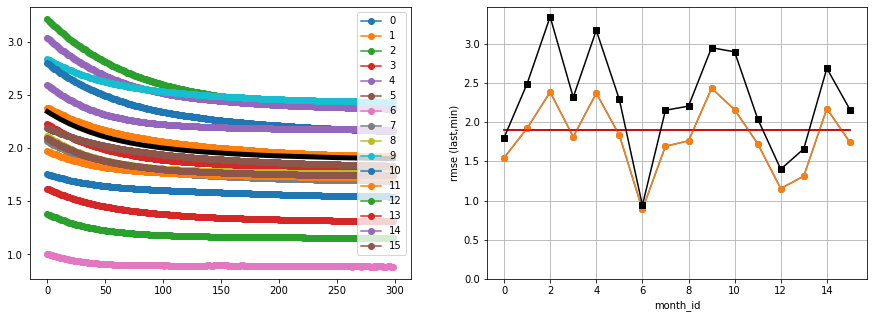

In [19]:
# PERFORMANCE ANALYSIS
performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset)

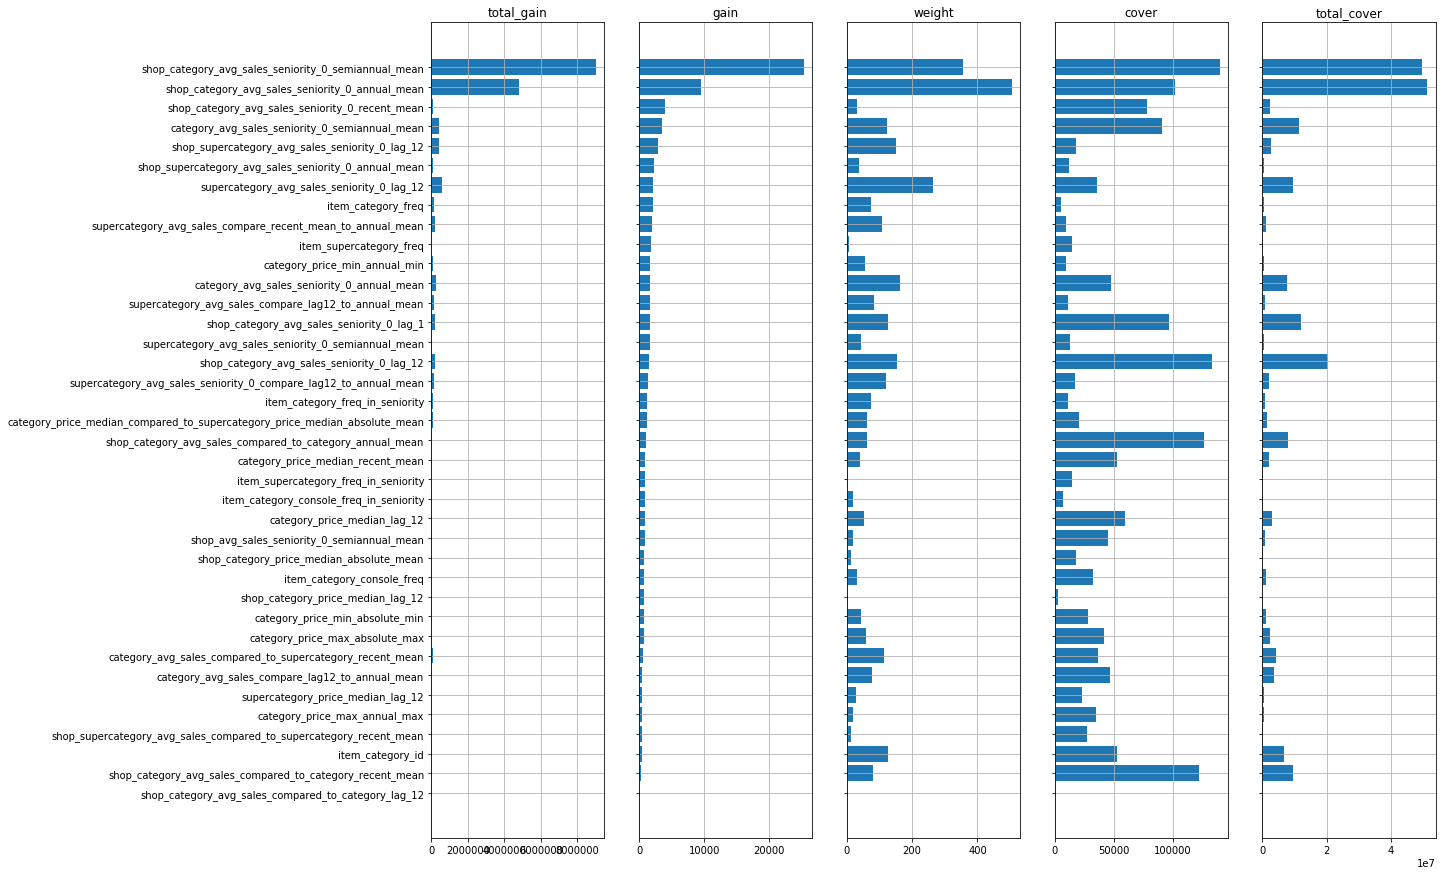

In [20]:
# FEATURE IMPORTANCE
plot_feature_importance(xgbreg,X_train)

### Save model and test set

In [21]:
# create directory
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/xgbreg_seniority0'))

# export model
pickle.dump(xgbreg, open(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority0/model.pickle'), 'wb'))
X_test.to_pickle(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority0/X_test.pkl'))

directory ../data/predictions/models/xgbreg_seniority0 created succesfully !


In [22]:
# clear memory
del X_train, Y_train, X_test
del eval_set
del rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset
del xgbreg

gc.collect()

41414

In [23]:
reset_variable_space